# Identifying temporal variation in EvoDevo data with MEFISTO

This notebook demonstrates how temporal (or spatial) covariates can be used for multimodal data integration to learn smooth latent factors while benefiting from the multimodal `MuData` objects from `muon`.

Please find more information about this method — *MEFISTO* — [on its website](https://biofam.github.io/MOFA2/MEFISTO) and [in the preprint](https://www.biorxiv.org/content/10.1101/2020.11.03.366674v1) by Britta Velten et al.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import muon as mu

In [2]:
# Set the working directory to the root of the repository
import os
os.chdir("../")

## Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample. The data can be downloaded [from here](https://figshare.com/s/242916198fde3353f3e6).

In [3]:
datadir = "data/evodevo"

In [4]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

/usr/local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


First, we create a collection of AnnData objects from this dataframe, one for each organ.

For instance, here's the data for the `'Brain'` view:

In [5]:
brain = data[data.view == 'Brain'].pivot(index='sample', columns='feature', values='value')
brain

feature,ENSG00000000457_Brain,ENSG00000001084_Brain,ENSG00000001167_Brain,ENSG00000001461_Brain,ENSG00000001561_Brain,ENSG00000001617_Brain,ENSG00000001629_Brain,ENSG00000001631_Brain,ENSG00000002549_Brain,ENSG00000002745_Brain,...,ENSG00000267909_Brain,ENSG00000268104_Brain,ENSG00000269058_Brain,ENSG00000270885_Brain,ENSG00000271092_Brain,ENSG00000271503_Brain,ENSG00000271601_Brain,ENSG00000272442_Brain,ENSG00000272886_Brain,ENSG00000273079_Brain
sample,,,,,,,,,,,,,,,,,,,,,
10wpc_Human,8.573918,8.875957,11.265237,7.374965,7.311018,9.959839,10.542619,9.692082,9.180280,4.281878,...,7.221091,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,11.74615
11wpc_Human,8.439675,8.737682,10.855314,8.066544,7.354726,10.431113,10.308780,9.242115,9.350255,3.363064,...,7.116983,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.421384,1.178014,11.28160
12wpc_Human,8.399178,8.916387,12.555510,9.253555,8.763702,9.946536,11.530929,10.033949,9.278142,4.322361,...,4.000716,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,2.664630,1.178014,13.97646
13wpc_Human,8.637347,8.831740,10.916489,9.190959,8.158240,10.279600,11.287268,9.510370,9.033614,4.784136,...,5.635512,1.178014,1.481758,1.178014,1.178014,1.178014,1.178014,1.776655,1.178014,12.47349
16wpc_Human,8.525125,8.575862,11.271736,8.177629,7.857303,10.363036,11.402954,9.523244,8.833177,2.785827,...,6.119527,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,2.413222,1.178014,13.73805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
senior_Human,8.437410,9.898419,8.216911,11.504150,9.958047,6.857990,9.623469,9.205518,9.884420,4.484028,...,3.862928,1.178014,2.254255,1.178014,1.178014,1.178014,1.178014,2.581292,1.178014,11.67438
teenager_Human,8.429526,9.949921,8.637132,11.680144,10.211024,6.452668,10.214713,9.604091,9.903370,5.265158,...,3.162686,1.178014,1.178014,1.178014,1.453269,1.178014,1.178014,3.016177,1.178014,12.54986
toddler_Human,8.333979,10.027861,8.693345,11.691258,9.731870,7.191969,10.286671,8.958592,10.120605,5.322412,...,5.152286,1.178014,1.648489,1.178014,1.178014,1.178014,1.178014,3.201100,1.178014,12.81460


In [6]:
views = data.view.unique()
data_list = [data[data.view == m].pivot(index='sample', columns='feature', values='value') for m in views]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods

{'Brain': AnnData object with n_obs × n_vars = 83 × 7696,
 'Cerebellum': AnnData object with n_obs × n_vars = 83 × 7696,
 'Heart': AnnData object with n_obs × n_vars = 83 × 7696,
 'Liver': AnnData object with n_obs × n_vars = 83 × 7696,
 'Testis': AnnData object with n_obs × n_vars = 83 × 7696}

In addition, we keep the meta data for each sample, containing the developmental time points.

In [7]:
obs = (
    data[['sample', 'time', 'group']]
        .drop_duplicates()
        .rename(columns = {'group' : 'species'})
        .set_index('sample')
)
obs

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human


We now create a multimodal `MuData` object:

In [8]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

This contains both the gene expression data,

In [9]:
print(mdata)
mdata["Brain"]

MuData object with n_obs × n_vars = 83 × 38480
  obs:	'time', 'species'
  5 modalities
    Brain:	83 x 7696
    Cerebellum:	83 x 7696
    Heart:	83 x 7696
    Liver:	83 x 7696
    Testis:	83 x 7696


AnnData object with n_obs × n_vars = 83 × 7696

as well as the sample-level information given by the developmental time points, which are not yet matched for different species.

In [10]:
mdata.obs

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human


## Integrate data

**MEFISTO** can be run on a `MuData` object with `mu.tl.mofa` by specifying which variable (*covariate*) should be treated as *time*.

- To incorporate the time information, we specify which metadata column to use as a covariate for MEFISTO — `'time'`.

- We also specify `'species'` to be used as groups.

- In addition, we tell the model that we want to learn an alignment of the time points from different species by setting `smooth_warping=True` and using `'Mouse'` as reference.

- Using the underlying Gaussian process for each factor we can interpolate to unseen time points. This is enabled by providing `new_values`, which correspond to the covariate, i.e. time.

For illustration, we only use a small number of training iterations.

In [11]:
mu.tl.mofa(mdata, n_factors=5, 
           groups_label="species",
           smooth_covariate='time', smooth_warping=True,
           smooth_kwargs={"warping_ref": "Mouse", "new_values": list(range(1, 15))},
           outfile="models/mefisto_evodevo.hdf5",
           n_iterations=25)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' group='Opossum' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rabbit' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rat' with N=16 samples and D=7696 features...
Loade

## Visualization in the factor space

In [14]:
import seaborn as sns
palette = sns.color_palette("Set2")

Let's take a look at the decomposition learnt by the model.

... storing 'species' as categorical


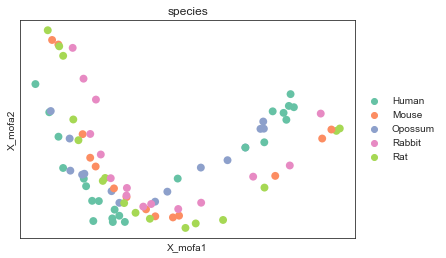

In [15]:
mu.pl.mofa(mdata, color="species", palette=palette, size = 250)

... storing 'species' as categorical


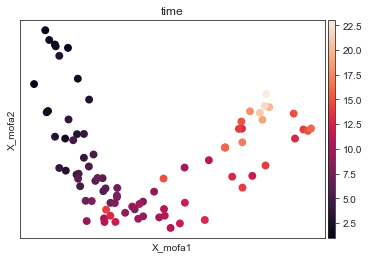

In [16]:
mu.pl.mofa(mdata, color="time", size = 250)

... storing 'species' as categorical


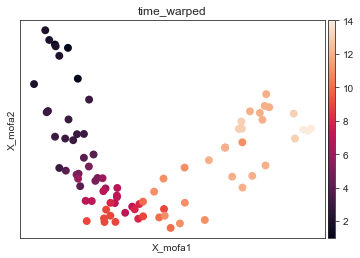

In [17]:
mu.pl.mofa(mdata, color="time_warped", size = 250)

## Latent factors versus common developmental time

We can plot the latent processes along the inferred common developmental time.

In [18]:
mdata.obs["Factor1"] = mdata.obsm["X_mofa"][:,0]

Before alignment:

... storing 'species' as categorical


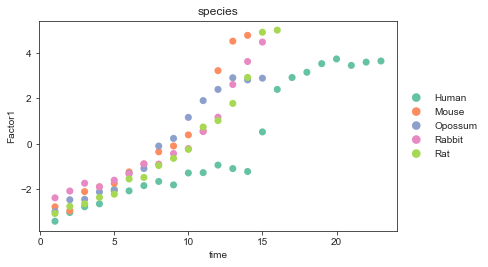

In [19]:
import seaborn as sns
sc.pl.scatter(mdata, x="time", y="Factor1", color="species", 
              palette=palette, size=200)

After alignment:

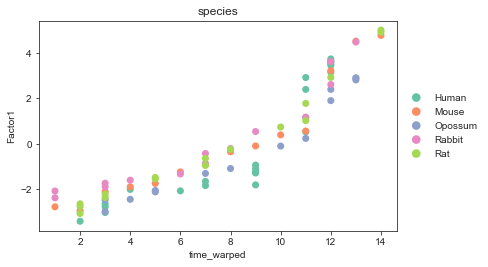

In [20]:
sc.pl.scatter(mdata, x="time_warped", y="Factor1", color="species", 
              palette=palette, size=200)

## Alignment

We can also take a look at the learnt alignemnt.

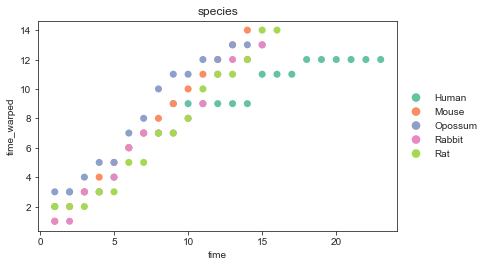

In [21]:
sc.pl.scatter(mdata, x="time", y="time_warped", color="species", 
              palette=palette, size=200)

## Further analyses

Additionally we can take a look at the smoothness and sharedness of the factors, interpolate the factors or cluster the species based on the learnt group kernel of each latent factor.

For that, we will use the [mofax](https://github.com/gtca/mofax) library that provides convenient loaders and plotting functions.

In [22]:
import mofax
model = mofax.mofa_model("models/mefisto_evodevo.hdf5")
model

MOFA+ model: mefisto evodevo
Samples (cells): 83
Features: 38480
Groups: Human (23), Mouse (14), Opossum (15), Rabbit (15), Rat (16)
Views: Brain (7696), Cerebellum (7696), Heart (7696), Liver (7696), Testis (7696)
Factors: 5
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 14 new values

### Interpolation

Using the underlying Gaussian process for each factor we can interpolate to unseen time points for species that are missing data in these time points or intermediate time points.

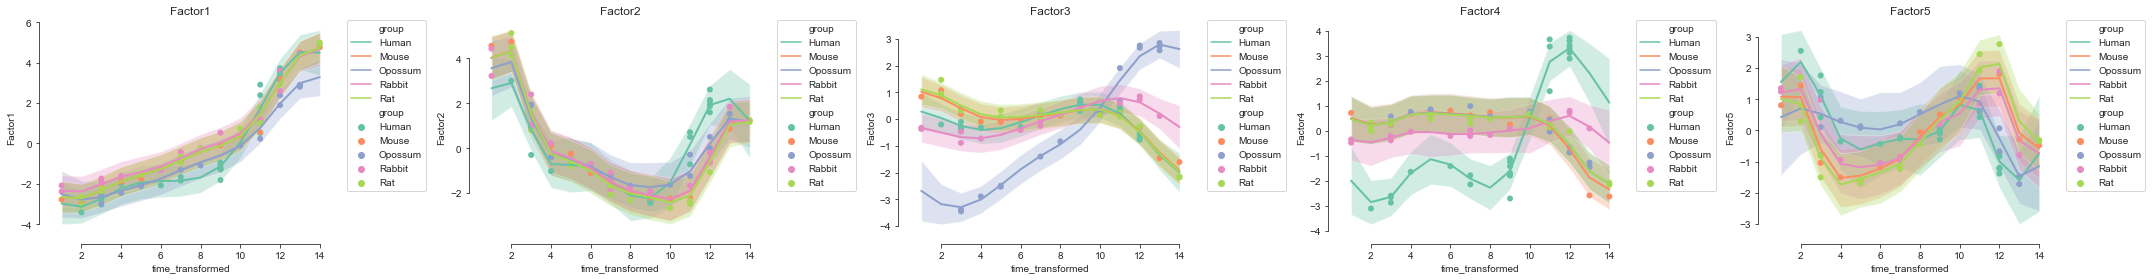

In [23]:
mofax.plot_interpolated_factors(model, factors=range(model.nfactors),
                                ncols=5, size=70);

### Smoothness and sharedness of factors

In addition to the factor values and the alignment the model also inferred an underlying Gaussian process that generated these values. By looking into it we can extract information on the smoothness of each factor, i.e. how smoothly it varies along developmental time, as well as the sharedness of each factor, i.e. how much the species (groups) show the same underlying developmental pattern and how the shape of their developmental trajectory related to a given developmental module (Factor) clusters between species.

The scale parameters of the Gaussian process capture the smoothness of the model. We will visualize them with bar plots where more colour means more smoothness:

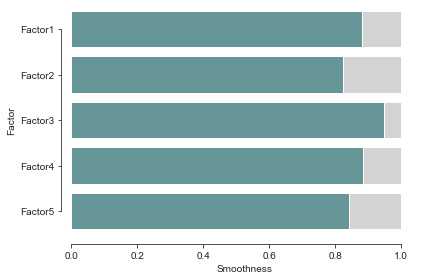

In [24]:
mofax.plot_smoothness(model);

The group kernel of the Gaussian process can give us insights into the extent to which a temporal pattern is shared across species for the developmental module captured by each process:

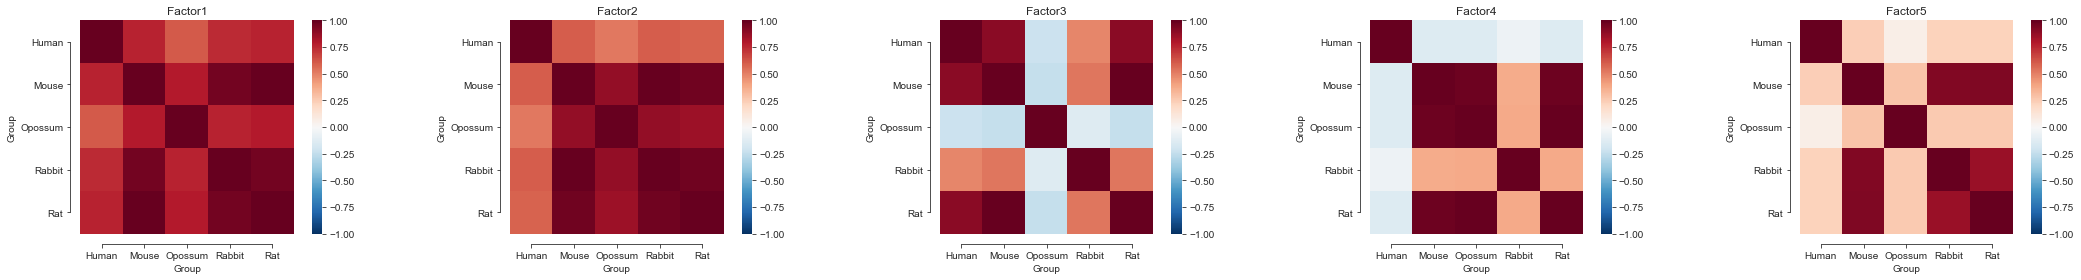

In [27]:
mofax.plot_group_kernel(model, ncols=5);

We can also plot _sharedness_ as a feature for each factor (fully coloured bar means fully shared):

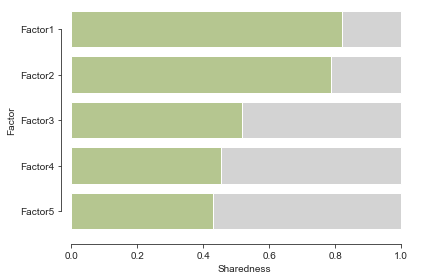

In [29]:
mofax.plot_sharedness(model);